In [196]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('cm1.arff')
df = pd.DataFrame(data[0])

df.defects = df.defects.apply(lambda x: x.decode('utf-8'))
df.defects = df.defects.astype('category')

df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,false
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,true
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1.0,0.0,6.0,0.0,15.0,15.0,44.0,19.0,9.0,false
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0.0,0.0,3.0,0.0,16.0,8.0,31.0,16.0,7.0,false
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0.0,0.0,3.0,0.0,16.0,12.0,46.0,26.0,11.0,false


In [197]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def knnCrossValidation(data, labels, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    return cross_val_score(knn, data, labels, cv=5)

In [198]:
#preparing data
X = df.copy()
X = X.drop(columns=['defects'])
y = df['defects']

knnCrossValidation(X, y, 2).mean()

0.885591836734694

In [199]:
import math

def euclideanDistance(i1, i2):
    sum = 0
    for i in range(len(i1) - 1):
        sum += math.pow((i1[i] - i2[i]), 2)
    return math.sqrt(sum)

distances = []

for i in df.drop(columns=['defects']).values:
    d = []
    for j in df.drop(columns=['defects']).values:
        d.append(euclideanDistance(i, j))
    distances.append(d)

In [200]:
import random

def midPoint(p1, p2):
    mid = []
    for i in range(len(p1)):
        mid.append((p1[i] + p2[i])/2)
    return mid
    
def selectRandomPrototypes(numPrototypes, trainBase):
    prototypes = []
    f = numPrototypes//2
    t = numPrototypes - f
    
    i = numPrototypes
    while i > 0:
        r = random.randint(0, len(trainBase)-1)
        p1 = trainBase.iloc[r]
        found = False
        p2 = None
        while not found:
            r = random.randint(0, len(trainBase)-1)
            p2 = trainBase.iloc[r]
            if p2.defects == p1.defects:
                found = True
        mid = midPoint(p1.values[:len(p1)-1], p2.values[:len(p2)-1])
        mid.append(p1.defects)
        if p1.defects == 'false' and f > 0:
            prototypes.append(mid)
            f -= 1
            i -= 1
        if p1.defects == 'true' and t > 0:
            prototypes.append(mid)
            t -= 1
            i -= 1
    return pd.DataFrame(prototypes)

In [335]:
def alpha(t):
    return math.exp(1-1/(t+1)**2)

In [336]:
from sklearn.neighbors import NearestNeighbors
def lvq1(trainBase, numPrototypes):
    prot = selectRandomPrototypes(numPrototypes, trainBase)
    prot.columns = trainBase.columns
    for i in range(len(trainBase)):
#         r = random.randint(0, len(trainBase)-1)
        x = trainBase.iloc[i]
        
        oneNN = NearestNeighbors(n_neighbors=1)
        oneNN.fit(prot.drop(columns=['defects']).values)
    
        distances, indices = oneNN.kneighbors(x.values[:len(x)-1].reshape(1, -1))
        nearestProt = prot.iloc[indices[0][0]]
        if nearestProt.defects != x.defects:
            # get more distant
            nearestProt = nearestProt.drop(labels=['defects']) + alpha(i) * (x.drop(labels=['defects']) - nearestProt.drop(labels=['defects']))
        else:
            # get closer
            nearestProt = nearestProt.drop(labels=['defects']) - alpha(i) * (x.drop(labels=['defects']) - nearestProt.drop(labels=['defects']))
        nearestProt['defects'] = prot.iloc[indices[0][0]].defects
        prot.iloc[indices[0][0]] = nearestProt
            
    return prot

In [344]:
def test(knnK, data, lvq):
    numProts = [4, 5, 10, 15, 20, 50, 100, 150]
    accuracy = []
    for x in numProts:
        prototypesDataset = lvq(data, x)
        knn = KNeighborsClassifier(n_neighbors=knnK)
        knn.fit(prototypesDataset.drop(columns=['defects']), prototypesDataset['defects'])
        prediction = knn.predict(data.drop(columns=['defects']))
        good = 0
        bad = 0
        for i in range(len(prediction)):
            if prediction[i] == data.iloc[i].defects:
                good += 1
            else:
                bad += 1

        accuracy.append([x, good/len(df)])

    accuracy = pd.DataFrame(accuracy)
    return accuracy

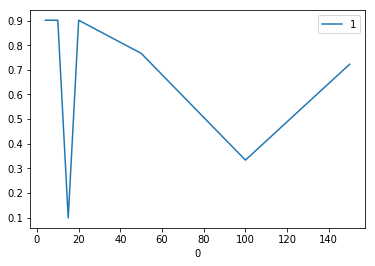

In [345]:
test(1, df, lvq1).plot.line(x=0, y=1)

In [ ]:
def inRange(i, j, x, s):
    di = euclideanDistance(i, x)
    dj = euclideanDistance(j, x)
    
    if min(di/dj, dj/di) > s:
        return True
    
def lvq2(trainBase, numPrototypes):
    prot = selectRandomPrototypes(numPrototypes, trainBase)
    prot.columns = trainBase.columns
    
    for i in range(len(trainBase)):
#         r = random.randint(0, len(trainBase)-1)
        x = trainBase.iloc[i]
        
        oneNN = NearestNeighbors(n_neighbors=2)
        oneNN.fit(prot.drop(columns=['defects']).values)
    
        distances, indices = oneNN.kneighbors(x.values[:len(x)-1].reshape(1, -1))
        nearestProt = prot.iloc[indices[0][0]]
        secNearestProt = prot.iloc[indices[0][1]]
        s = (1 - 10)/(1 + 10)
        if inRange(nearestProt, secNearestProt, x, s): 
            if nearestProt.defects != secNearestProt.defects:
                if nearestProt.defects != x.defects:
                    # get more distant
                    nearestProt = nearestProt.drop(labels=['defects']) + alpha(i) * (x.drop(labels=['defects']) - nearestProt.drop(labels=['defects']))
                    secNearestProt = secNearestProt.drop(labels=['defects']) - alpha(i) * (x.drop(labels=['defects']) - secNearestProt.drop(labels=['defects']))
                else:
                    # get closer
                    nearestProt = nearestProt.drop(labels=['defects']) - alpha(i) * (x.drop(labels=['defects']) - nearestProt.drop(labels=['defects']))
                    secNearestProt = secNearestProt.drop(labels=['defects']) + alpha(i) * (x.drop(labels=['defects']) - secNearestProt.drop(labels=['defects']))

        nearestProt['defects'] = prot.iloc[indices[0][0]].defects
        secNearestProt['defects'] = prot.iloc[indices[0][1]].defects
        
        prot.iloc[indices[0][0]] = nearestProt
        prot.iloc[indices[0][1]] = secNearestProt
            
    return prot

In [ ]:
test(3, df, lvq2).plot.line(x=0, y=1)

In [ ]:
test(1, df, lvq2).plot.line(x=0, y=1)